In [1]:
import csv
import pandas as pd
import operator
import xgboost
from xgboost import XGBRegressor # you have to install it first!
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew 
color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
sample = pd.read_csv(r'all\sample_submission.csv', sep = ',')
sample.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


# Test file

In [3]:
test = pd.read_csv(r'all\test.csv', sep = ',')
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# set of columns with at least one NaN value
nan_dict = {}
for col in test:
    nan_count = test[test[col].isna()]
    if len(nan_count) > 0:
        nan_dict[col] = len(nan_count)
        
sorted_nan = sorted(nan_dict.items(), key = operator.itemgetter(1))
sorted_nan.reverse()

In [5]:
# creating a set of columns names (with NaN values in test)
test_li = set()
for i in range(len(sorted_nan)):
    test_li.add(sorted_nan[i][0])

In [7]:
len(test_li)

33

In [8]:
numerical_feature_nan_to_zero = ['BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                                 'GarageArea', 'GarageCars', 'GarageYrBlt', 'MasVnrArea', 
                                 'TotalBsmtSF']
string_feature_nan_to_none = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                             'BsmtQual','GarageQual', 'GarageCond', 'GarageFinish', 
                             'GarageType', 'MasVnrType']

# test['Functional'] = test['Functional'].fillna('Typ')  
# nella descrizione dice di assumere typical se non specificato

# alley la droppiamo

# per Exterior1st e 2nd lascio il replace della pipeline perche ci deve stare per forza 
# un exterior covering of the house
# test['Fence'] = test['Fence'].fillna('None') DROP
# test['FireplaceQu'] = test['FireplaceQu'].fillna('None') DROP

# Kitchen quality: ci sta per forza una cucina quindi lascio quello della pipeline

# test['LotFrontage'] = test['LotFrontage'].fillna(0)  MEGLIO MEDIAN?


# ms zonning lascio la pipeline

# pool qc e  misc features la droppiamo
# test['SaleType'] = test['SaleType'].fillna('None') MEGLIO MOST FREQUENT
# per utilities lascio la pipeline

**Alley** has 107 null values and the remaining are NaN.  ---> drop ?

**MiscFeature** has 3 second garage, 2 other, 46 shed and the remaining 1408 are missing. We can drop it since we don't need these informations. 

**MiscVal** has 51 different values and the remaining 1408 are missing (*except* miscval = 17000, miscfeature = nan).

**PoolArea** has 1453 zeroes and the remaining 6 are different values. 

**PoolQC** has 2 excellent and 1 good values, the remaining 3 are NaN. The information is not reliable.  ---> drop

# Train

In [9]:
train = pd.read_csv(r'all\train.csv', sep = ',')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
# set of columns with at least one NaN value
nan_dict_train = {}
for col in train:
    nan_count_train = train[train[col].isna()]
    if len(nan_count_train)>0:
        nan_dict_train[col] = len(nan_count_train)
        
sorted_nan_train = sorted(nan_dict_train.items(), key = operator.itemgetter(1))
sorted_nan_train.reverse()

## Handling with missing values

### An Extension To Imputation

In [11]:
#dropped_test = test.drop('Id', axis = 1) VIENE FATTO DOPO

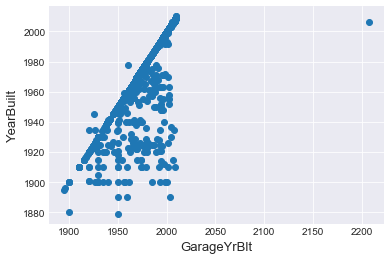

In [12]:
# there was an outlier in GarageYrBlt
fig, ax = plt.subplots()
ax.scatter(x = test['GarageYrBlt'], y = test['YearBuilt'])
plt.ylabel('YearBuilt', fontsize = 13)
plt.xlabel('GarageYrBlt', fontsize = 13)
plt.show()

In [13]:
outlier = test[test['GarageYrBlt'] > 2018]
test.loc[test.GarageYrBlt > 2018, 'GarageYrBlt'] = test['YearBuilt']

In [19]:
train = train.drop(train[(train.TotalBsmtSF > 5000) & ( train.SalePrice < 200000)].index)

In [20]:
drop_test_col = [tup[0] for tup in sorted_nan[:6]]
imp_test_col = [tup[0] for tup in sorted_nan[6:]]

In [21]:
# dropping the columns with a higher number of missing values
to_drop = ['Id', 'Utilities', 'Condition2']
dropped_test = test.drop(drop_test_col, axis = 1)
dropped_test = dropped_test.drop(to_drop, axis = 1)
dropped_train = train.drop(drop_test_col, axis = 1)
dropped_train = dropped_train.drop(to_drop, axis = 1)

In [22]:
# distinguishing categorical and numeric features
str_feature = [i for i in dropped_test.columns 
            if isinstance(dropped_test[i][0], str)]
num_feature = [i for i 
               in (set(dropped_test.columns).difference(str_feature))]

In [23]:
str_featureSet = set(str_feature)
str_featureSet -= set(string_feature_nan_to_none)

str_feature = list(str_featureSet)

In [24]:
# make copy to avoid changing original data (when Imputing)
new_test = dropped_test.copy()
new_train = dropped_train.copy()
reduced_train = new_train.drop('SalePrice', axis = 1)
final_train_y = np.log1p(train['SalePrice'].astype('float'))

# string conversion from nan to None
str_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'None')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

# numeric conversion from nan to constant
num_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', StandardScaler())])

# numeric conversion from nan to median
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

# string conversion from nan to most_frequent
str_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers = [('cat_std', str_default_transformer, string_feature_nan_to_none),
        ('num_std', num_default_transformer, numerical_feature_nan_to_zero),
        ('num', num_transformer, num_feature),
        ('cat', str_transformer, str_feature)])

In [25]:
coefs = []
lambdas = (0.00001, 0.0001, 0.001, 0.01)
for lambda_ in lambdas:

    clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', Lasso(alpha = lambda_, max_iter = 50000))])
    train_fit = clf.fit(reduced_train, final_train_y)
    predictions = clf.predict(new_test)
    coefs.append(train_fit.steps[1][1].coef_)

(-0.05, 0.2936759767469059)

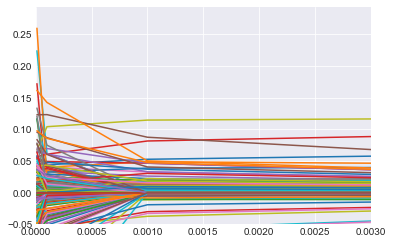

In [26]:
plt.plot(lambdas, coefs)
plt.xlim(0,0.003)
plt.ylim(-0.050,) # good lambda seems 0.00075

# Modelling

In [27]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier',Lasso(alpha = 0.0004, max_iter = 50000))])
print(cross_val_score(clf, reduced_train, final_train_y, cv = 5))  

train_fit = clf.fit(reduced_train, final_train_y)
predictions = clf.predict(new_test) 
# [0.92534889 0.87682961 0.91042009 0.91388471 0.78388089] 0.00075
# [0.92600298 0.87685387 0.91081945 0.9147973  0.78533819] 0.0007
# [0.92660061 0.87692102 0.91110397 0.91565979 0.78683613] 0.00065
# [0.92852987 0.87390091 0.90821394 0.92056336 0.79420127] 0.0003
# [0.92872172 0.87587015 0.90979528 0.91936181 0.79263166] 0.0004

[0.92709875 0.86736737 0.91082221 0.92347614 0.91379081]


In [28]:
clf.named_steps['preprocessor'].transformers
#support = clf.named_steps['rfe_feature_selection'].support_
#feature_names = np.array(train.columns) # transformed list to array
#feature_names[support]

[('cat_std', Pipeline(memory=None,
       steps=[('imputer', SimpleImputer(copy=True, fill_value='None', missing_values=nan,
         strategy='constant', verbose=0)), ('onehot', OneHotEncoder(categorical_features=None, categories=None,
         dtype=<class 'numpy.float64'>, handle_unknown='ignore',
         n_values=None, sparse=True))]), ['BsmtCond',
   'BsmtExposure',
   'BsmtFinType1',
   'BsmtFinType2',
   'BsmtQual',
   'GarageQual',
   'GarageCond',
   'GarageFinish',
   'GarageType',
   'MasVnrType']),
 ('num_std', Pipeline(memory=None,
       steps=[('imputer', SimpleImputer(copy=True, fill_value=0, missing_values=nan,
         strategy='constant', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['BsmtFullBath',
   'BsmtFinSF1',
   'BsmtFinSF2',
   'BsmtUnfSF',
   'GarageArea',
   'GarageCars',
   'GarageYrBlt',
   'MasVnrArea',
   'TotalBsmtSF']),
 ('num', Pipeline(memory=None,
       steps=[('imputer', SimpleImputer(copy=True, fill_value

In [29]:
pred_sale_price = pd.DataFrame(np.expm1(predictions), 
                               columns = ['SalePrice'], index = None)
pred_sale_price['Id'] = test['Id']
pred_sale_price['SalePrice'] = ((pred_sale_price['SalePrice'] + 250)/ 500).astype(int) * 500

cols = pred_sale_price.columns.tolist()
cols = cols[-1:] + cols[:-1]
pred_sale_price = pred_sale_price[cols]

In [30]:
pred_sale_price.to_csv('predictions.csv', index = False)